## Pass Utility Maximization/Minimization in NFL Football

#### Background

Pass plays are a significant portion of NFL football games and are often called in crucial situations. Prior to the snap, the defense aligns itself in a coverage scheme with the intent to prevent a successful pass play. In this project, we quantify the success of a passing play at every second after the snap and we compare the success or utility of the passing play over time across various coverage schemes. We also quantify the marginal value each defensive position has in terms of preventing success on a pass play and study this marginal value over time and across different coverage schemes.

#### Utility Function

In various fields, utility functions are used to quantify the reward associated with a certain activity. In economics, the utility function of a crime is the probability of arrest multiplied by the severity of punishment. In international politics, the utility function of a threat under deterrence or compellence is the probability of the threat being carried out multiplied by the severity of the threat. In crime, the criminal attempts to commit crime with a low utility function, while the police attempt to maximize the utility of crimes. In international relations, the threatened party attempts to minimize the utility of a threat while the threatening party attempts to maximize the utility of the threat. 

We define a utility function for a pass play as the probability of pass completion multiplied by the expected yardage gain of the pass. The offensive team will attempt to maximize the utility of pass plays, while the defensive team will attempt to minimize the utility of the pass play.

Formally, $u(p) = p(completion) \cdot E(Yards)$ where p is a given play.

#### Probability of Pass Completion

The probability of pass completion is calculated at every time stamp in a given play. We estimate the probability of pass completion using a random forest ensemble learning method with 100 tree estimators. The tree estimators will each "vote" on the class to which the training instance should belong (complete or incomplete) and the probability of completion will be defined as the number of trees which voted 1 divided by the total number of trees.

Formally, $p(completion) = \frac{\sum_{i=1}^{n} C_i (x) = 1}{n}$ where C is the class prediction of the ith decision tree and n is the number of decision trees (in this case, 100).

The random forest estimator is trained on various features to ensure an accurate probability prediction at each point in each play. This is a supervised learning method as we find plays which either contain the event "complete" or "incomplete" and build a labeled dataset with data from the time of pass arrival. The features we use to train the model are the euclidean distance of a defender from the closest offensive weapon (QB, WR, TE, RB), a simulated openness metric for each offensive weapon, speed of each weapon and defender, and the acceleration of each weapon and defender.

The euclidean distance ($\sqrt{(X_2 - X_1)^{2} + (Y_2 - Y_1)^{2}}$) of a defender from the closest offensive weapon is calculated by finding a defender's distance from each weapon and finding the minimum of this vector. The simulated openness metric is found by taking a weapon and calculating the sum of all of the defenders who are closest to the weapon, and finding the average change in this sum if the weapon moves in any of the four directions, North, South, East, or West. (a higher average indicates that the weapon is more open and can create distance from the defender). 

The simulated openness metric can be calculated using the following formula: 

$(\sum_{i = 1}^{n}{\sqrt{(X_2 - (X_1+1))^{2} + (Y_2 - Y_1)^{2}}} - \sum_{i = 1}^{n}{\sqrt{(X_2 - X_1)^{2} + (Y_2 - Y_1)^{2}}} + \sum_{i = 1}^{n}{\sqrt{(X_2 - (X_1-1))^{2} + (Y_2 - Y_1)^{2}}} - \sum_{i = 1}^{n}{\sqrt{(X_2 - X_1)^{2} + (Y_2 - Y_1)^{2}}} + \sum_{i = 1}^{n}{\sqrt{(X_2 - X_1)^{2} + (Y_2 - (Y_1+1))^{2}}} - \sum_{i = 1}^{n}{\sqrt{(X_2 - X_1)^{2} + (Y_2 - Y_1)^{2}}} + \sum_{i = 1}^{n}{\sqrt{(X_2 - X_1)^{2} + (Y_2 - (Y_1-1))^{2}}} - \sum_{i = 1}^{n}{\sqrt{(X_2 - X_1)^{2} + (Y_2 - Y_1)^{2}}}) \div 4$

The speed and acceleration of each weapon and defender are provided in the dataset. Therefore, a vector with the euclidean distance between defender and their closest weapon, an openness metric for each weapon, and the speed and acceleration for each defender and weapon is entered as an input into the random forest model, and each of the 100 decision trees assign a class to the vector and the average assignment is the $p(completion)$.

The model used SMOTE (Synthetic Minority Oversampling Technique) to generate synthetic incomplete passes as the dataset was imbalanced and had more completions compared to incompletions. The model has an AUC value of 0.932. We also display the ROC Curve below. The ROC curve is calculated by finding the true positive rate and false positive rate for each cutoff threshold and AUC is the area under this curve. Formally, $ ROC = \forall c, (TPR(c), FPR(c))$ and $AUC = \int_{0}^{1} ROC(t)dt$.


Code to generate the datasets used to fit the pass probability prediction model can be found in extract_linefitdf.py.

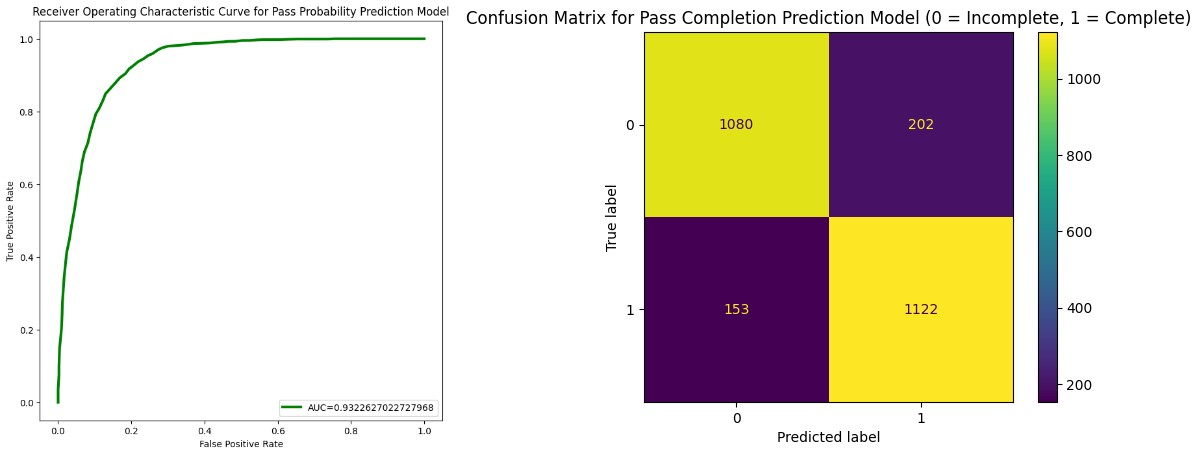

#### Expected Yardage Gain

The second component of the utility function is the expected yardage gain. The expected yardage gain can be calculated by finding the distance of a receiver (WR, TE, RB) from the line of scrimmage and finding the projected yards after catch. The distance of the receiver from the line of scrimmage can be found using provided data while the yards after catch requires a different approach. 

We first attempted to use a linear regression model to estimate the yards after catch, however, we realized that there may be a nonlinear relationship between the given features and outcome, as the model performance was very low and there was heteroscedasticity with error terms having a clear pattern.

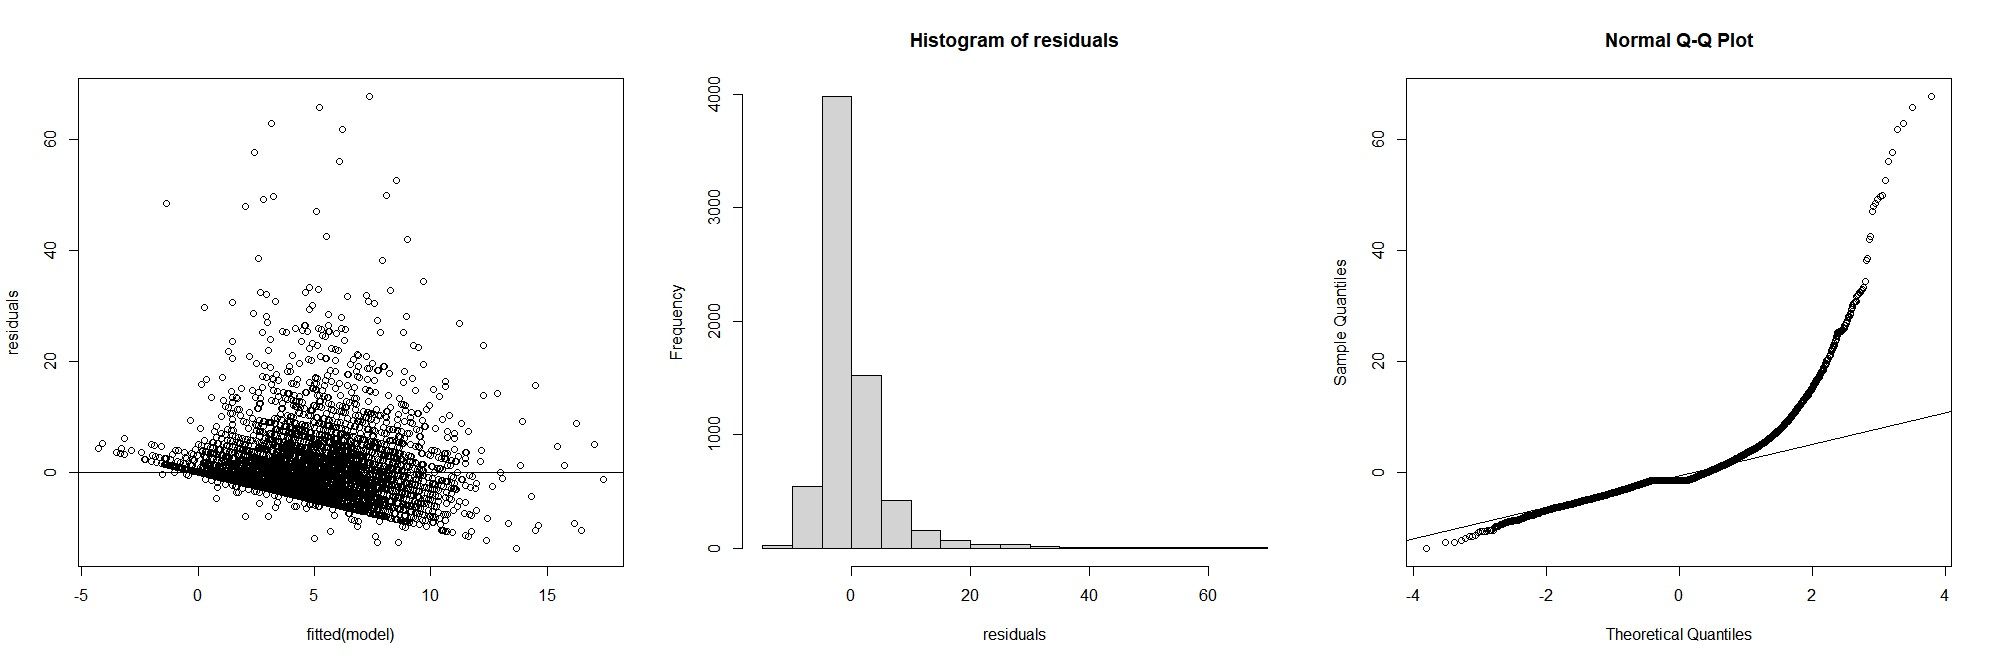

We then decided to use a random forest regression algorithm with one hundred decision tree estimators to estimate the yards after catch of a given receiver. The function to estimate yards after catch can be stated as $f(x) = \frac{1}{n} \cdot \sum_{i=1}^{n} T_i (x)$ where $T_i(x)$ represents the prediction of the ith tree given the vector x. In other words, the random forest model takes the average of continuous predictions from the one hundred decision tree estimators. The ground truth values are the true yards after catch for a given play, while the features used to fit the model are the openness metric at time of pass arrival, the euclidean distances of defenders who are closest to the receiver, and receiver and defender speed and acceleration. The features used to fit the model are all collected at the time of pass arrival. The model trained on these features and labels performs well, and the given predictors are able to explain 86% of the variance in yards after catch. In other words, $0.86 = 1 - \frac{{\sum_{i=1}^{n}(y_{i} - \hat y_i)^{2}}}{\sum_{i=1}^{n}(y_i - \bar y)^{2}}$. 

It is important to note that the sum of the distance from line of scrimmage and the projected yards after catch for each receiver only tells us how many yards that particular receiver is expected to gain. Furthermore, the probability distribution of the chance that a receiver is targeted is not uniform, meaning that different receivers have different probabilities of being targeted dependent on their openness during the play. For that reason, we decided to calculate an openness percentage which is measured by for a given receiver, taking the sum of euclidean distances of defenders who are closest and adding to that the openness metric of the receiver, and dividing that by the sum of this formula when applied to all receivers in the play. Mathematically, the openness percentage is $Opennesspercentage = \frac{\sum{(distancefromweapon)} + opennessmetric}{\sum_{i=1}^{n} \sum{distancefromweapon_i} + opennessmetric_i}$ where n is the number of receivers in the play. This openness percentage models the probability that a receiver will be targeted on the play, and we can use this probability to calculate a weighted expectation of the yardage gained on the play. 

In summary, the expected yardage gain will be the sum for all receivers of the probability of being targeted times the sum of the distance from the line of scrimmage and the forecasted yards after catch. $E(y) = \sum_{i=1}^{n} {p(target) \cdot (distancefromline + yac)}$ where n is the total number of receivers in the play.

The code to generate the dataset to fit this model is found in extract_linefitdf.py.

#### Play Utility

After we have established a utility function for a pass play, we now run this function on the provided plays at every second. This allows us to analyze the utility of a passing play over time since the snap. In other words, at every second of every play, the product of pass completion probability and expected yardage gain is calculated. These calculations are only done for ~ 850 plays due to computational complexity of feature extraction at every second of every play. After collecting utility measures over time since snap for each of these 850+ plays, we can then analyze the utility over time across different coverage schemes.

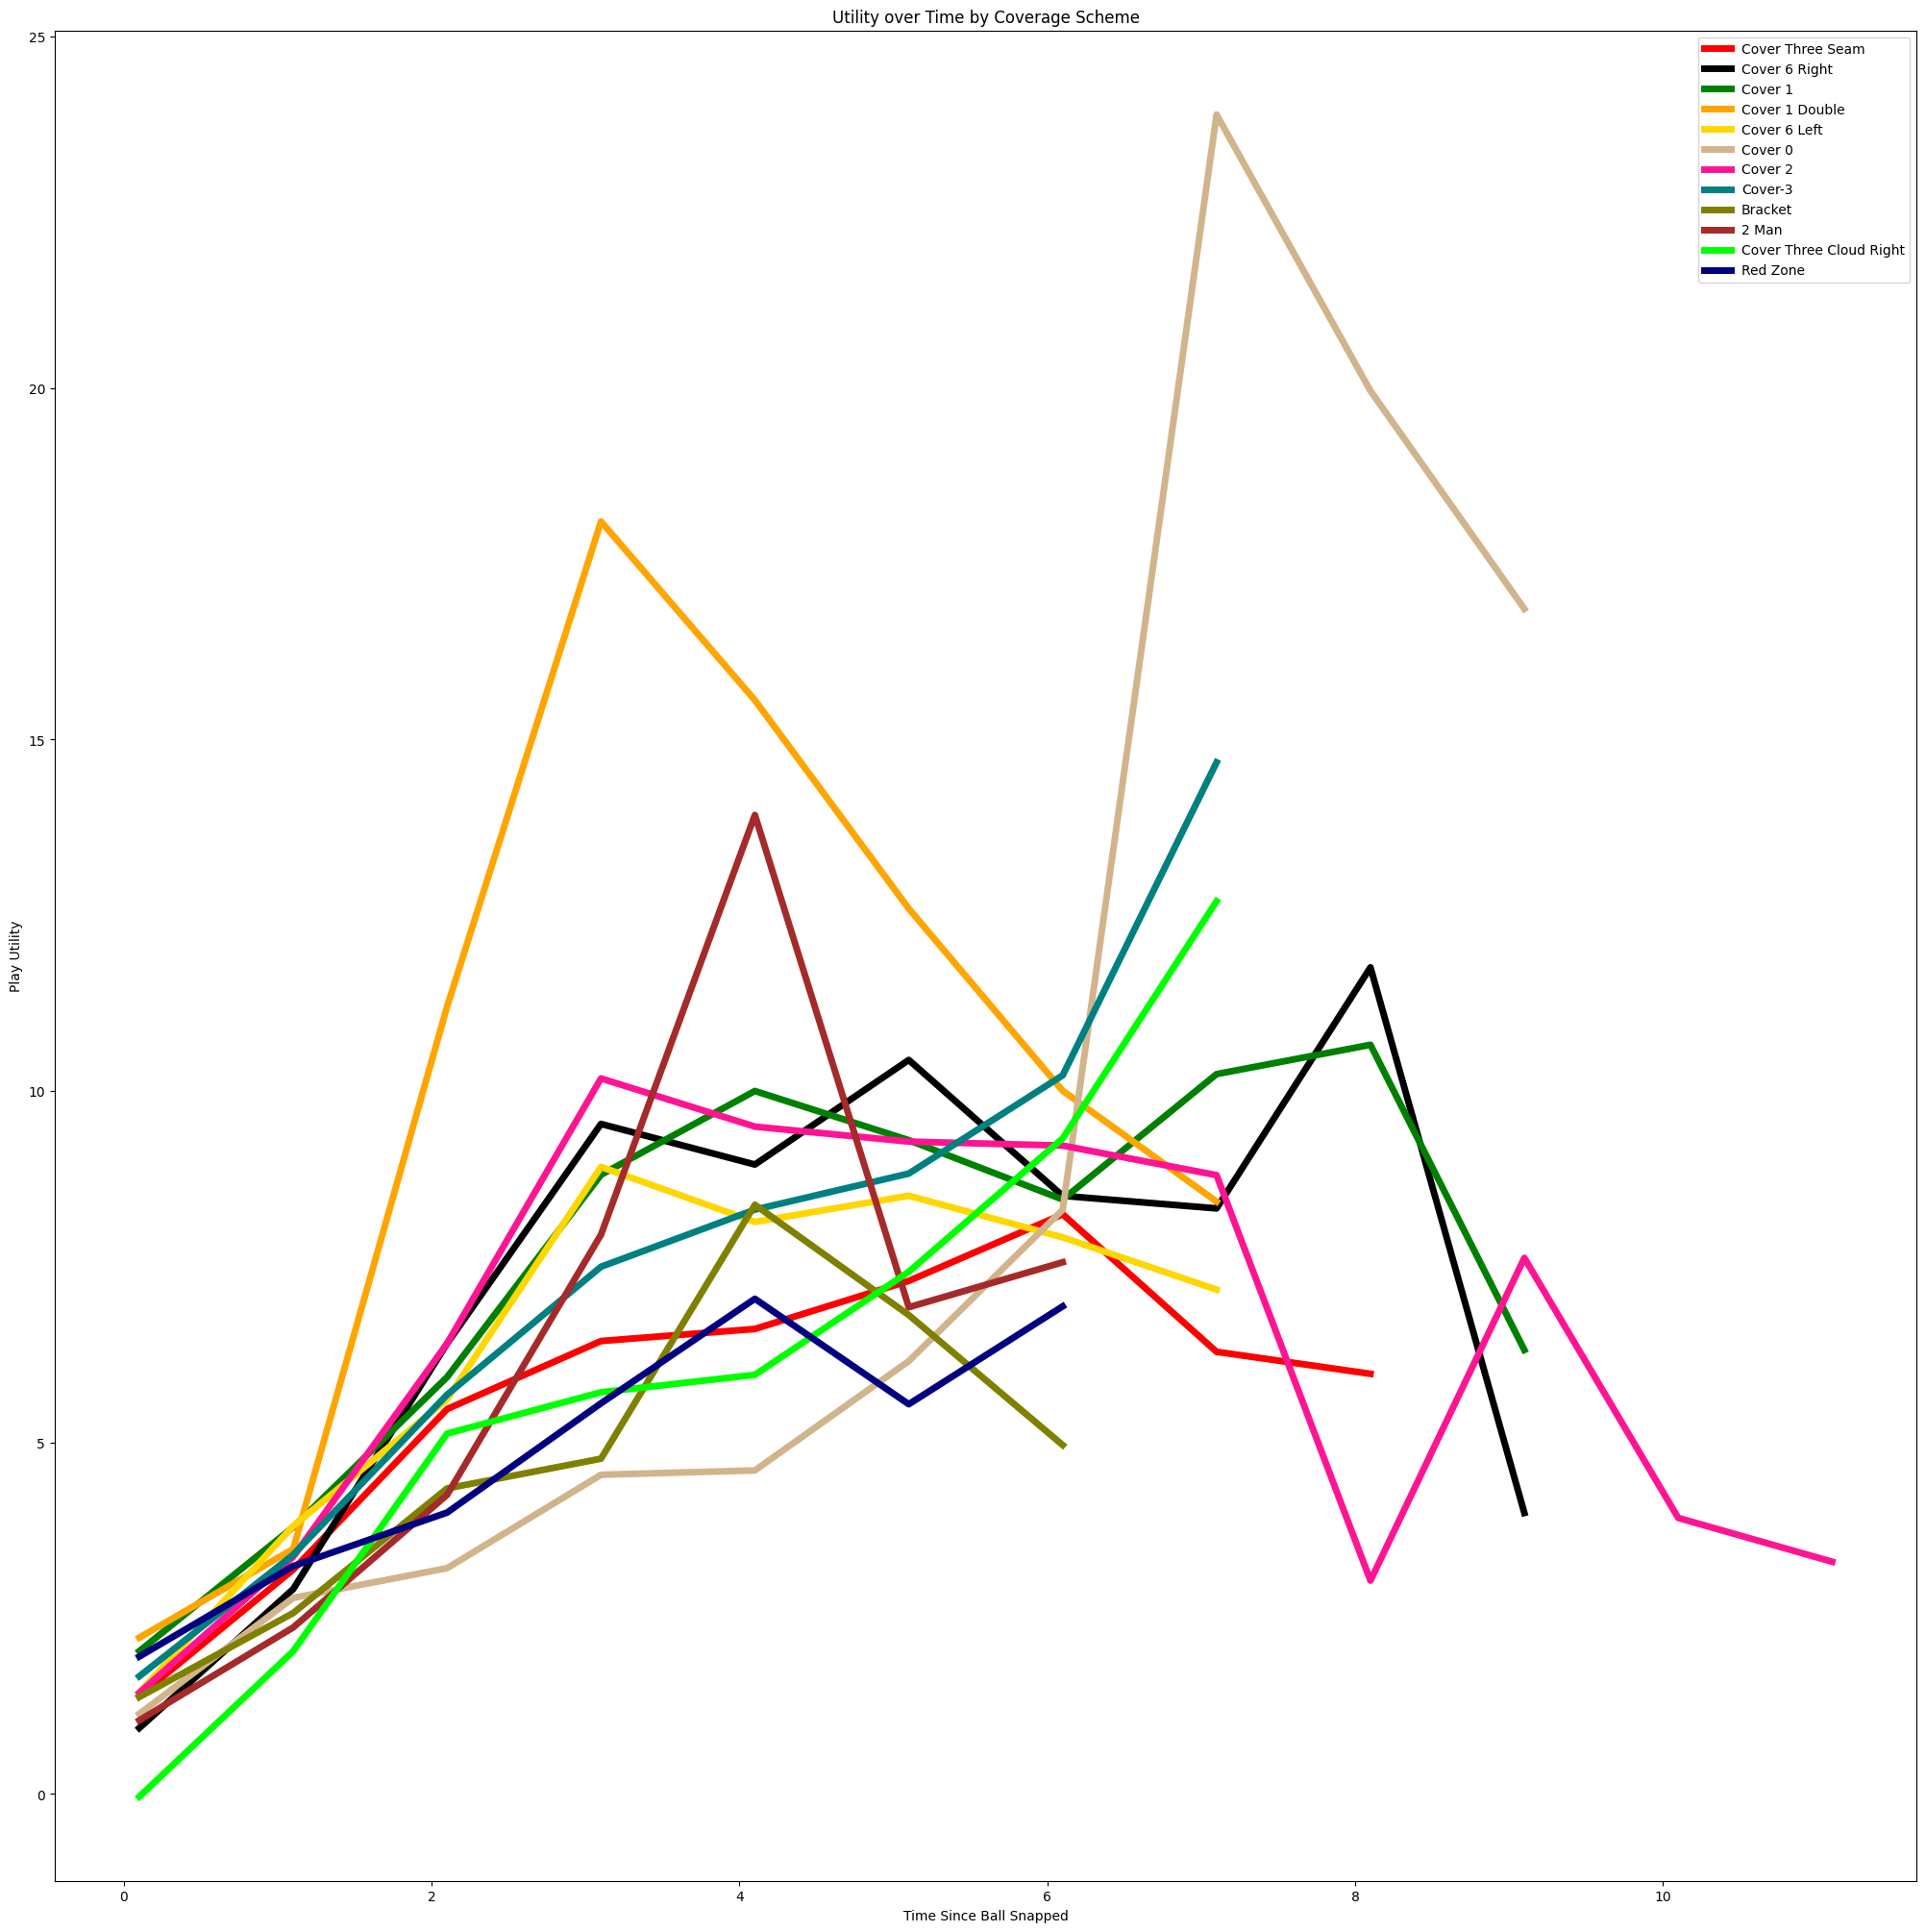

This graph shows us the average utility at each second after snap for each coverage scheme. From this data, we can see some interesting trends. We can see that for Cover 0, the utility in the early seconds of the play is extremely low but skyrockets as the play progresses. This makes sense, as Cover 0 is a high risk high reward coverage scheme where intense pressure is placed on the quarterback and receivers are covered by only one defender. In the early seconds, the quarterback likely has lots of pressure and thus the utility is low; however, over time, the receivers might be able to create lots of seperation from a single defender leading to a spike in the utility of the play. Cover 2 on the other hand, seems to allow a high utility early in the play, but this decays over time. This is likely because cover 2 is a zone coverage where short passes early in the play might be easy to make but long passes later in the play may be challenging. It also seems like cover 1 double allows for higher utility than other coverages, which means it may be wise for defenses to forgo this coverage scheme, and it may be wise for offensive teams to call short pass plays when they establish that the defense is aligned in the cover-1 double scheme prior to the snap.

This graph allows us to see general trends in the utility of plays according to the defensive coverage; however, we also develop a quantitative approach to calculate the utility of a play over time in a given coverage. We use a two degree polynomial interpolation which minimizes the least squares $\sum{(y_i - \hat y_i)^{2}}$ to estimate the utility of a play given time under a certain defensive coverage scheme.

We only performed this interpolation for the six most common coverage schemes (Cover 3, Cover 1, Quarters, Cover 2, Cover 0, Cover-6 Right) as the other coverages may not have a large enough sample size to fit an accurate interpolation.

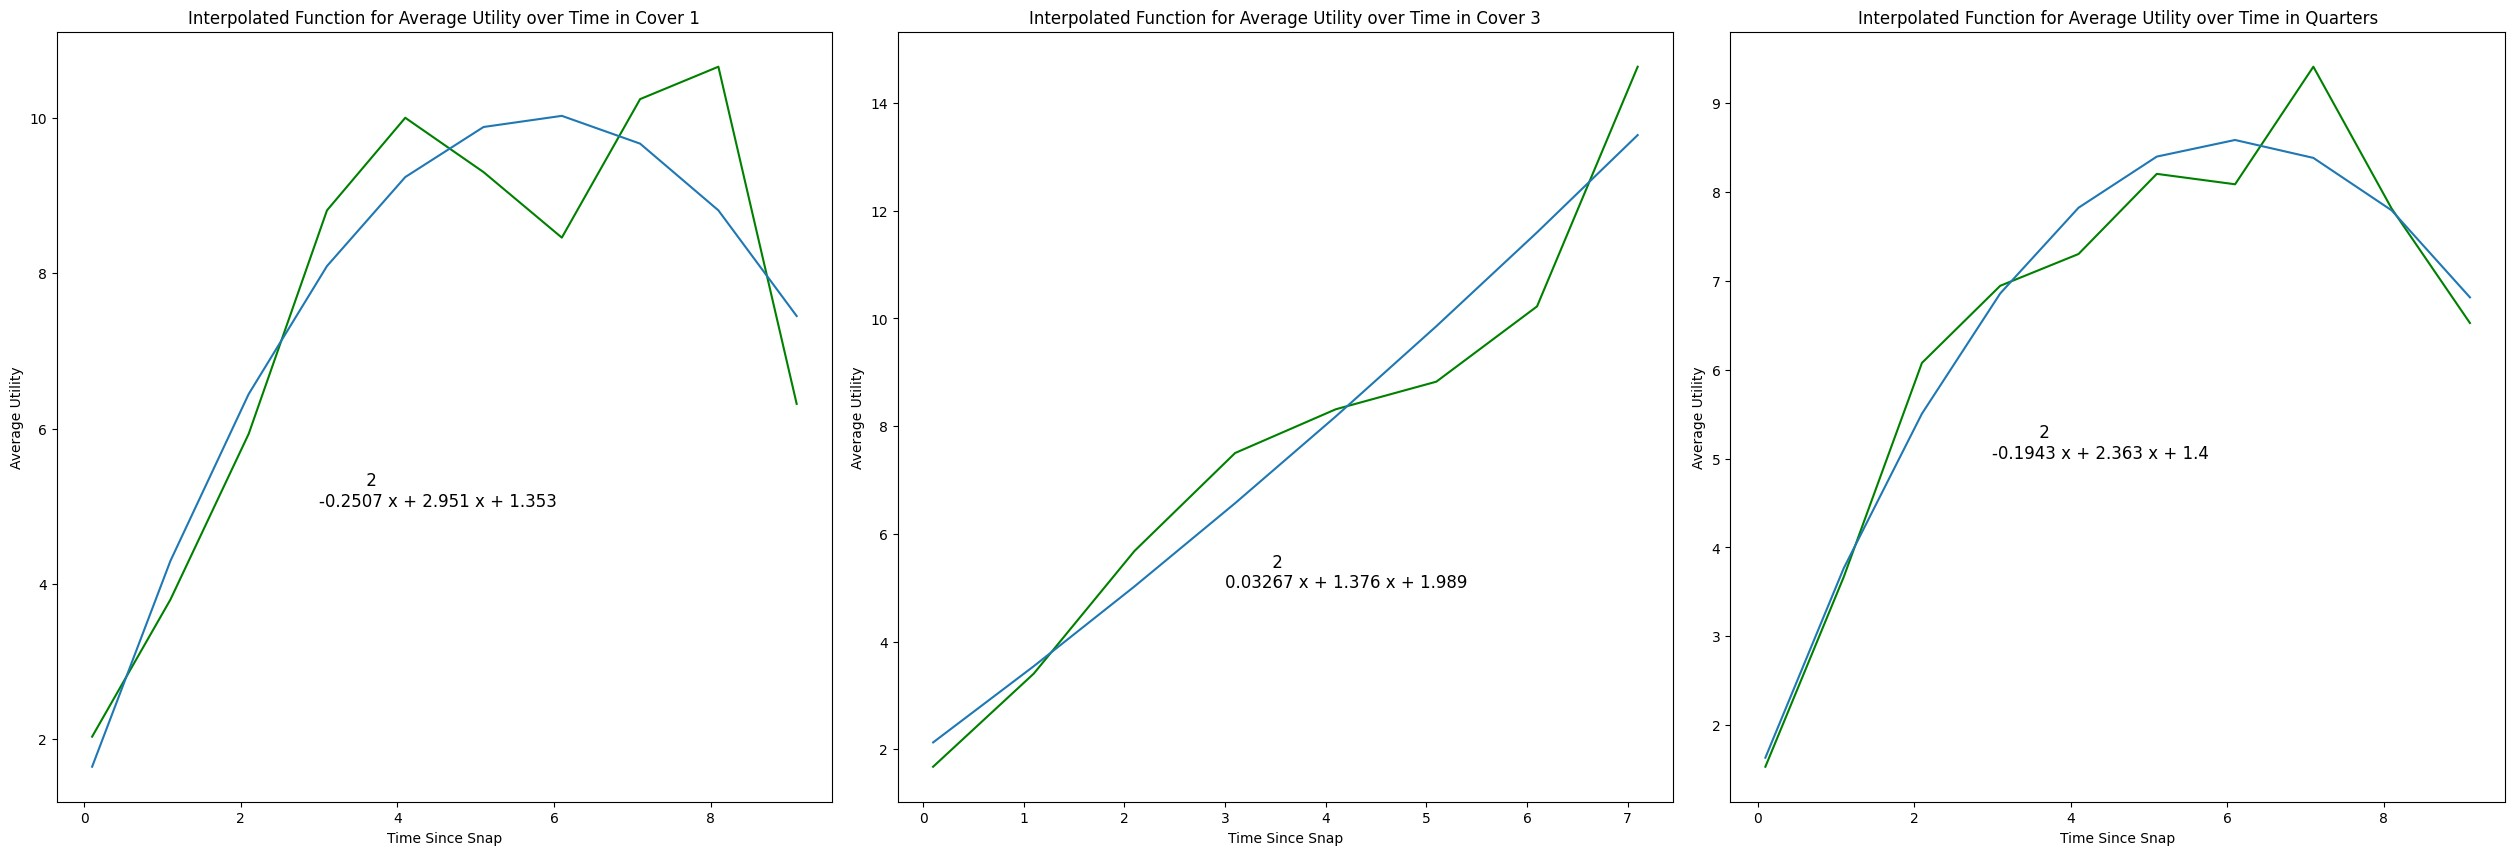

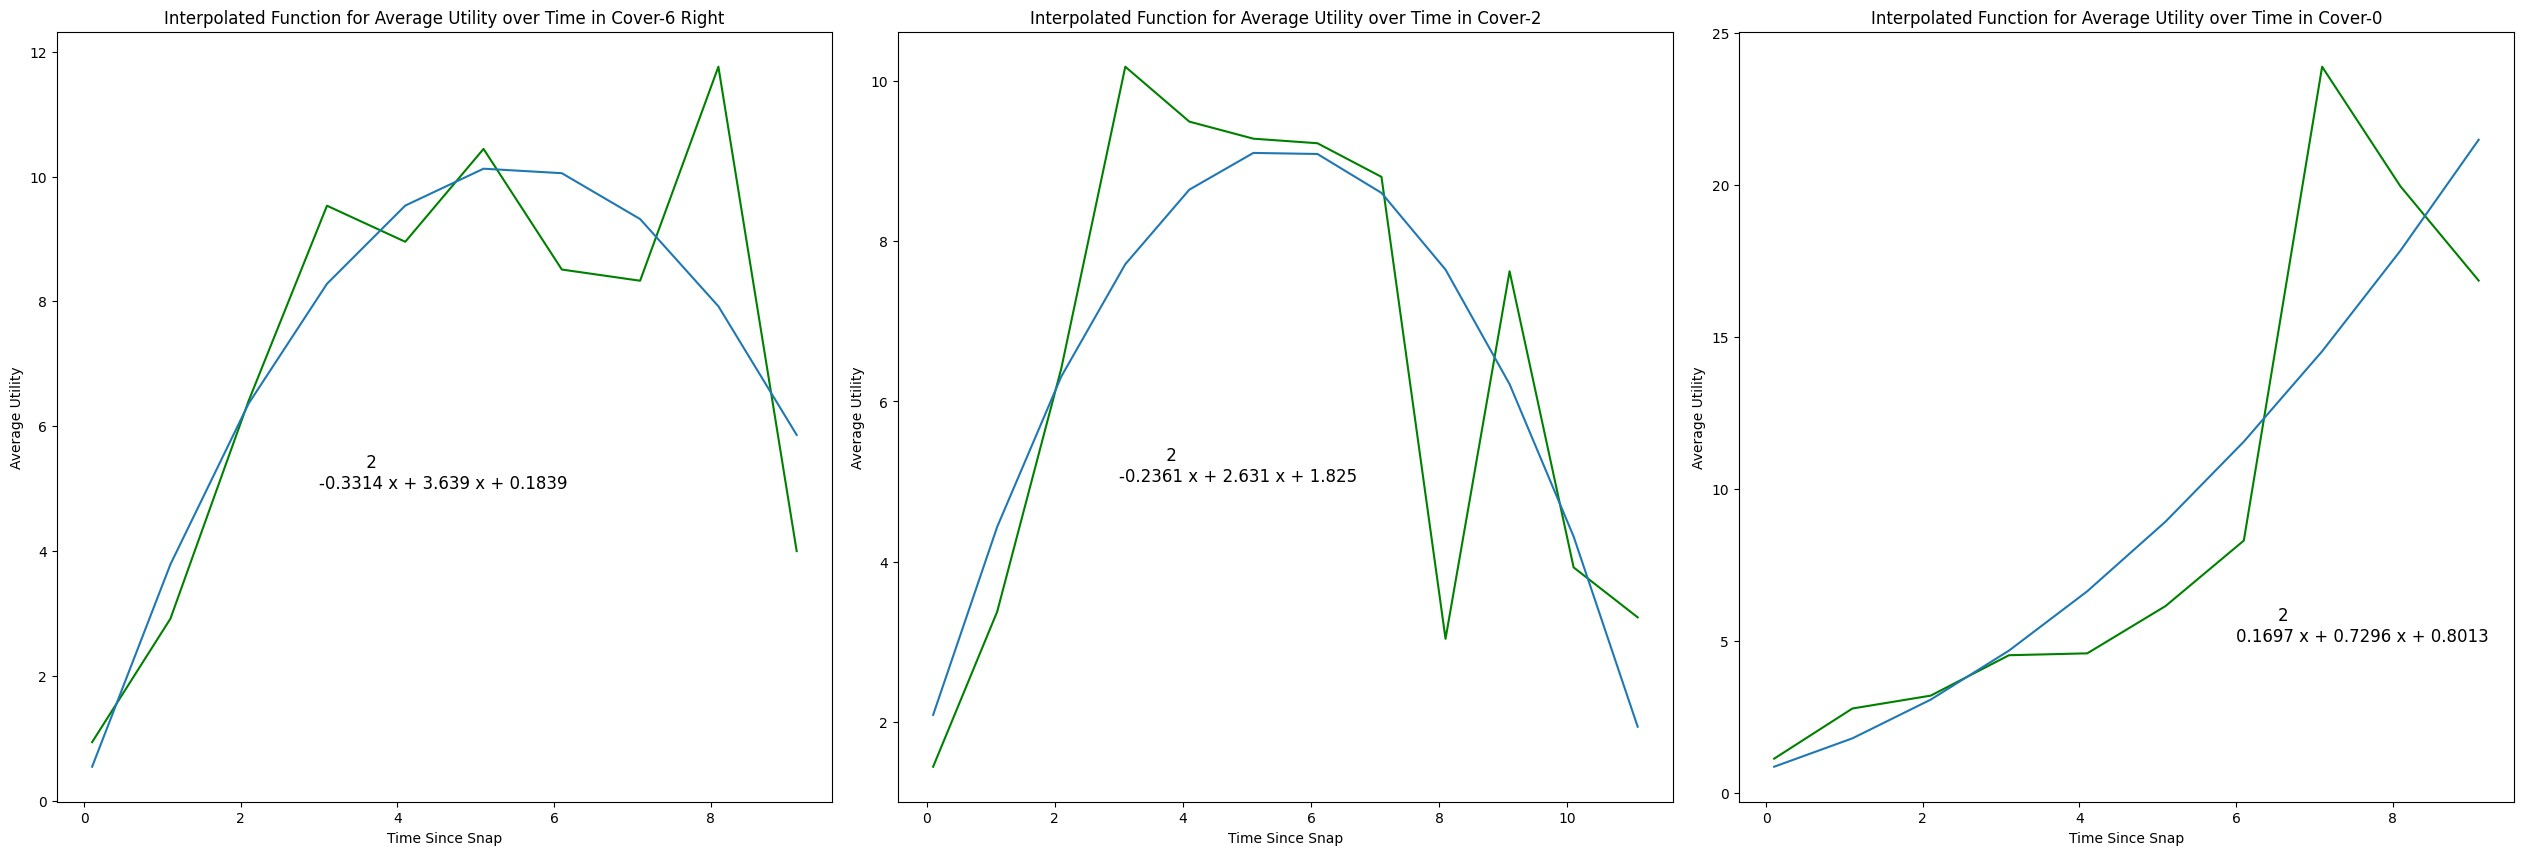

Under each coverage scheme, we can see an equation that should estimate the utility of the play over time. The utilities are different over time and certain coverages may be called to defend against certain types of pass plays. We define an early pass as a pass made within the first three seconds of a play, we define an average pass as a pass made between three and six after the snap and we define a late pass as one made six or more seconds after the snap. We can integrate the utility functions over these three chunks to determine which coverage scheme results in the greatest utility for each play type.

If the play is a early pass, $\int$